In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import re
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
from sklearn import linear_model
from scipy.stats import pearsonr, spearmanr
import importlib

def importlib_reload(lib_name):
    importlib.reload(sys.modules[lib_name])

# sys.path.append(os.path.join('..','UTILS'))
# from cosamp_fn import cosamp
# cosamp function is available at https://github.com/avirmaux/CoSaMP
# copy function from ipynb into cosamp_fn.py and place in UTILS folder

# plt.rcParams['figure.figsize'] = [12, 12]
# plt.rcParams.update({'font.size': 18})

In [3]:
import pandas as pd
import networkx as nx
from sklearn.utils import shuffle
from collections import Counter

# from ..QAOAKit import (
#     opt_angles_for_graph,
#     get_fixed_angles,
#     get_graph_id,
#     get_graph_from_id,
#     angles_to_qaoa_format,
#     beta_to_qaoa_format,
#     gamma_to_qaoa_format,
#     angles_to_qiskit_format,
#     angles_to_qtensor_format,
#     get_3_reg_dataset_table,
#     get_3_reg_dataset_table_row,
#     get_full_qaoa_dataset_table_row,
#     get_full_qaoa_dataset_table,
#     get_fixed_angle_dataset_table,
#     get_fixed_angle_dataset_table_row,
#     qaoa_maxcut_energy,
#     noisy_qaoa_maxcut_energy,
#     angles_from_qiskit_format,

# )

# from QAOAKit.compressed_sensing import (
#     cosamp,
#     one_D_CS_p1_recon_with_given_landscapes_and_varing_sampling_frac,
#     recon_by_Lasso
# )



In [7]:
# def recon_by_Lasso(Theta, y, alpha=0.1):
#     n = Theta.shape[1]
#     lasso = linear_model.Lasso(alpha=alpha)# here, we use lasso to minimize the L1 norm
#     # lasso.fit(Theta, y.reshape((M,)))
#     lasso.fit(Theta, y)
#     # Plotting the reconstructed coefficients and the signal
#     # Creates the fourier transform that will most minimize l1 norm 
#     recons = idct(lasso.coef_.reshape((n, 1)), axis=0)
#     recons += lasso.intercept_
#     return recons

In [4]:
def cal_recon_error(x, x_recon, residual_type):
    # print(x.shape, x_recon.shape)

    # assert len(x.shape) == 1 or len(x.shape) == 2 and x.shape[1] == 1
    # assert len(x_recon.shape) == 1 or len(x_recon.shape) == 2 and x_recon.shape[1] == 1

    x = x.reshape(-1)
    x_recon = x_recon.reshape(-1)

    diff = x - x_recon

    if residual_type == 'MIN_MAX':
        res = np.sqrt((diff ** 2).mean()) / (x.max() - x.min())
    elif residual_type == 'MEAN':
        res = np.sqrt((diff ** 2).mean()) / x.mean()
    elif residual_type == 'MSE':
        res = np.sqrt((diff ** 2).mean())
    elif residual_type == 'CROSS_CORRELATION':
        res = np.correlate(x_recon, x, mode='valid')
        # print(res)
        # assert np.isclose(res[0], np.sum(x_recon * x))
        res = res[0] / np.sqrt(np.sum(x_recon ** 2) * np.sum(x ** 2))
    elif residual_type == 'CONV':
        # print(x_recon.shape)
        # print(x_recon.shape, x.shape)
        res = np.convolve(x_recon, x) # take x as filter
        # print(res)
        res = res[0]
        # assert np.isclose(res[0])
        # return res[0]
    elif residual_type == 'ZNCC':
        res = 0
        # res = np.sum((x_recon - x_recon.mean()) * (x - x.mean())) / np.sqrt(x_recon.var() * x.var())
    else:
        assert f"Invalid residual_type {residual_type}"

    return res 

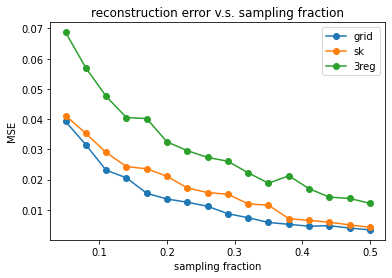

In [5]:

def plot_recon_error_vs_sf(sfs, recon_path_dict):
    # vary sampling fractions
    # origin = np.load("google_grid.npz", allow_pickle=True)['energies']['mitis']
    
    # print(np.array(origin))
    # origin = np.array(origin)
    # print
    data_types = ['grid', 'sk', '3reg']
    # sfs = np.arange(0.05, 0.3, 0.02)
    
    recon_es = {label: [] for label in data_types}

    for label in data_types:
        # data = np.load(f"recons_{label}.npz", allow_pickle=True)
        data = np.load(recon_path_dict[label], allow_pickle=True)
        recons = data['recons'].tolist()
        origin = data['origin']

        # residual_type = 'CONV'
        # residual_type = 'CROSS_CORRELATION'
        # residual_type = 'ZNCC'
        residual_type = 'MSE'

        for i, sf in enumerate(sfs):

            recon_e = cal_recon_error(origin, recons[i]['unmitis'], residual_type)


            # print(recon_e)
            # for label, error in recon_e.items():
            #     # print(error)
            #     recon_es[label].append(error)
            recon_es[label].append(recon_e)

    fig, axs = plt.subplots()
    for label, errors in recon_es.items():
        axs.plot(sfs, errors, marker='o', label=label)
    # for error in recon_es:
    # axs.plot(sfs, recon_es, marker='o', label="grid")
        
    axs.legend()
    axs.set_xlabel('sampling fraction')
    axs.set_ylabel(f'{residual_type}')
    axs.set_title(f'reconstruction error v.s. sampling fraction')
    plt.savefig("../paper_figs/MSE_vs_sf.png", dpi=200, bbox_inches='tight')
    plt.show()

# importlib_reload('QAOAKit.compressed_sensing')
sfs = np.arange(0.05, 0.5, 0.03)
recon_path_dict = {
    'grid': "2022-10-03_15:19:01/recons_grid.npz",
    "3reg": "2022-10-03_14:56:35/recons_3reg.npz",
    "sk": "2022-10-03_15:12:19/recons_sk.npz"
}
plot_recon_error_vs_sf(sfs, recon_path_dict)

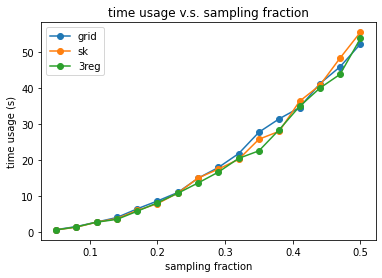

In [6]:

# sk = [0.530087, 1.365803, 4.032805, 6.149849, 10.513856, 13.533538, 16.164777, 21.576201,
#      27.124903, 31.313417, 36.446754, 43.309781, 46.781164, 52.409669]

sk = [0.527959, 1.289736, 2.682810, 3.690074, 5.956879, 7.842423, 10.805631, 14.978684,
     17.479327, 20.194243, 25.795569, 28.007915, 36.369922, 40.813939, 48.430299, 55.603489]
reg3 = [0.523730, 1.353509, 2.684634, 3.460168, 5.727766, 8.093807, 10.742766, 13.610563,
        16.635020, 20.461509, 22.566001, 28.463700, 34.931336, 40.025472, 43.898739, 53.869708]
grid = [0.593889, 1.446632, 2.713165, 3.983761, 6.402422, 8.595048, 10.953025, 14.935868,
        17.918882, 21.795427, 27.755789, 31.487459, 34.603668, 41.274977, 45.992941, 52.334438]

times_dict = {
    'grid': grid,
    'sk': sk,
    '3reg': reg3
}

def plot_time_vs_sf(sfs, times_dict: dict):
    # vary sampling fractions
    # origin = np.load("google_grid.npz", allow_pickle=True)['energies']['mitis']
    
    # print(np.array(origin))
    # origin = np.array(origin)
    # print
    # data_types = ['grid', 'sk', '3reg']
    # data_types = ['sk', '3reg']
    data_types = ['grid']

    # times_dict = {label: [] for label in data_types}

    # for label in data_types:
    #     data = np.load(f"recons_{label}.npz", allow_pickle=True)
    #     times = data['times']
    #     times_dict[label] = times
        # print(times)
        # times_dict[label] = [3.751044, 6.445278, 8.232543, 11.408934, 14.483946, 16.760700, 21.696105, 24.282870, 31.776780, 35.406588, 40.742857, 48.742751, 53.380392]
    fig, axs = plt.subplots()
    for label, errors in times_dict.items():
        axs.plot(sfs, times_dict[label], marker='o', label=label)
    # for error in recon_es:
    # axs.plot(sfs, recon_es, marker='o', label="grid")
        
    axs.legend()
    axs.set_xlabel('sampling fraction')
    axs.set_ylabel(f'time usage (s)')
    axs.set_title(f'time usage v.s. sampling fraction')
    plt.savefig("../paper_figs/time_vs_sf.png", dpi=200, bbox_inches='tight')
    plt.show()

# importlib_reload('QAOAKit.compressed_sensing')
plot_time_vs_sf(sfs, times_dict)

In [7]:
# 和这个文件无关，就是放在这里
# def draw_grad_errors():
#     grad_es = [0.20623547569107334, 0.21760078302546915, 0.49479478633243074]
#     labels = ['Ideal', 'Unmitigated', 'Mitigated']
    
#     fig, axs = plt.subplots()
#     # for label, errors in enumerate(grad_es):
#         # axs.plot(sfs, errors, marker='o', label=label)
#     axs.bar(labels, grad_es, width=0.4)

#     # axs.legend()
#     # axs.set_xlabel('')
#     axs.set_ylabel(f'cosine distance')
#     axs.set_title(f'reconstructed gradient error')
#     plt.savefig("../paper_figs/grad_errors.png", bbox_inches='tight', dpi=200)
#     plt.show()
# draw_grad_errors()

In [8]:
def _vis_p1_recon_google_data(
        origin_dict,
        recon_dict,
        # gamma_range,
        # beta_range,
        # C_opt, bound, var_opt,
        bounds,
        full_range,
        true_optima,
        # mitis_recon,
        # unmitis_recon,
        # ideal_recon,
        # xlabel,
        title,
        save_path,
        recon_params_path_dict=None,
        origin_params_path_dict=None
    ):

    
    # plt.figure
    plt.rc('font', size=28)
    # plt.rc('axes.facecolor', 'snow')
    # rcParams['axes.facecolor'] = 'white'
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(30, 35))
    fig.patch.set_facecolor('white')
    fig.suptitle(title, y=0.92)
    axs = axs.reshape(-1)

    # TODO Check ij and xy
    X, Y = np.meshgrid(full_range['beta'], full_range['gamma'])

    # c = ax.pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
    idx = 0
    for label, origin in origin_dict.items():
        recon = recon_dict[label]
        # axs[idx]
        # Z = np.array(Z).T
        # c = axs[idx].pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
        
        # im = axs[idx].imshow(origin)
        im = axs[idx].pcolormesh(X, Y, origin) #, cmap='viridis', vmin=origin.min(), vmax=origin.max())
        axs[idx].set_title(f"Experiment, {label}")
        if true_optima:
            axs[idx].plot(true_optima[1], true_optima[0], marker="o", color='red', markersize=7, label="true optima")
        axs[idx].set_xlabel('beta')
        axs[idx].set_ylabel('gamma')
        # axs[idx].set_xlim(bottom=full_range['beta'][0], top=full_range['beta'][-1])
        # axs[idx].set_xlim(left=bounds['beta'][0], right=bounds['beta'][1])
        # axs[idx].set_ylim(bottom=bounds['gamma'][0], top=bounds['gamma'][1])

        # im = axs[idx + 3].imshow(recon)
        im = axs[idx + 1].pcolormesh(X, Y, recon)
        axs[idx + 1].set_title(f"Reconstruct, {label}")
        if true_optima:
            axs[idx + 1].plot(true_optima[1], true_optima[0], marker="o", color='red', markersize=7, label="true optima")
        axs[idx + 1].set_xlabel('beta')
        axs[idx + 1].set_ylabel('gamma')
        # axs[idx + 3].set_xlim(left=bounds['beta'][0], right=bounds['beta'][1])
        # axs[idx + 3].set_ylim(bottom=bounds['gamma'][0], top=bounds['gamma'][1])

        # origin
        if origin_params_path_dict and label in origin_params_path_dict:
            xs = [] # beta
            ys = [] # gamma
            for param in origin_params_path_dict[label]:
                xs.append(param[1])
                ys.append(param[0])

            axs[idx].plot(xs, ys, marker="o", color='purple', markersize=5, label="optimization path")
            axs[idx].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial point")
            axs[idx].plot(xs[-1], ys[-1], marker="s", color='white', markersize=12, label="last point")

        # recon
        if recon_params_path_dict and label in recon_params_path_dict:
            xs = [] # beta
            ys = [] # gamma
            for param in recon_params_path_dict[label]:
                xs.append(param[1])
                ys.append(param[0])

            axs[idx + 1].plot(xs, ys, marker="o", color='purple', markersize=5, label="optimization path")
            axs[idx + 1].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial point")
            axs[idx + 1].plot(xs[-1], ys[-1], marker="s", color='white', markersize=12, label="last point")
        
        
        idx += 2

        
    # plt.legend()
    fig.colorbar(im, ax=[axs[i] for i in range(6)])
    # plt.title(title)
    # plt.subtitle(title)
    # fig.savefig(save_path, dpi=600, bbox_inches='tight')
    fig.savefig(save_path, bbox_inches='tight')
    plt.close('all')


labels = ['grid', '3reg', 'sk']
recon_path_dict = {
    'grid': "2022-10-03_15:19:01/recons_grid.npz",
    "3reg": "2022-10-03_14:56:35/recons_3reg.npz",
    "sk": "2022-10-03_15:12:19/recons_sk.npz"
}
origin_dict = {}
recon_dict = {}
# sfs = np.arange(0.05, 0.3, 0.02)
idx = -7
# sf = sfs[idx]
sf = 0.410
print(sf)

def get_bounds():
    data_path = f"./Google_Data/google_sk.npz"

    data = np.load(data_path, allow_pickle=True)

    # betas = data['betas']
    # gammas = data['gammas']
    # energies = data['energies']
    bounds = data['bounds'].tolist()
    return bounds

for label in labels:
    # data = np.load(f"recons_{label}.npz", allow_pickle=True)
    data = np.load(recon_path_dict[label], allow_pickle=True)
    recons = data['recons'].tolist()
    recon = recons[idx]['unmitis']
    # bounds = data['bounds']
    origin = data['origin']

    origin_dict[label] = origin
    recon_dict[label] = recon

bounds = get_bounds()
full_range = {
    "beta": np.linspace(bounds['beta'][0], 
        bounds['beta'][1],
        origin.shape[1]),
    "gamma": np.linspace(bounds['gamma'][0], bounds['gamma'][1], origin.shape[0]),
}

figdir = './google_data'
_vis_p1_recon_google_data(
    origin_dict=origin_dict,
    recon_dict=recon_dict,
    full_range=full_range,
    bounds=None,
    true_optima=None,
    title=f'Google Data, sampling fraction: {sf:.3f}',
    save_path=f'{figdir}/google_data_sf{sf:.3f}.png'
)

0.41


In [ ]:
# this is a good way to do so

